# Test 1 practice solutions


In [1]:
__author__ = 'mike-bowles'

import urllib2  ##Uncomment for Python 2
#from urllib.request import urlopen  ##Uncomment for Python 3
import numpy as np
target_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
data = urllib2.urlopen(target_url)  ##Uncomment for Python 2
#data = urlopen(target_url).read()  ##Uncomment for Python 3

In [45]:
x = []
y=[]
for row in data:   ##Uncomment for Python 2
#for row in data.decode('ascii').split('\n')[:-1]:    ##Uncomment for Python 3
    #print(row)
    #strip leading and trailing spaces and EOL and split on comma
    rowSplit = row.strip().split(',')
    #eliminate lines with missing data, convert to numeric, pull off id.  put data into x and labels into y.
    if not any('?' in word for word in rowSplit):
        numList = [float(w) for w in rowSplit]
        numList.pop(0)
        y.append(numList.pop(-1))
        x.append(numList)

#convert lists to numpy arrays
x = np.array(x)
print(x.shape)
y = np.array(y)
print(y.shape)


(683, 9)
(683,)


In [79]:
from sklearn.model_selection import train_test_split
#pull out 20% test set
xTrVa, xTe, yTrVa, yTe = train_test_split(x, y, test_size=0.2)
print(xTrVa.shape, xTe.shape, yTrVa.shape, yTe.shape)

((546, 9), (137, 9), (546,), (137,))


In [80]:
from sklearn.neighbors import KNeighborsRegressor
#set up xvalidation loop and run on sklearn knn regression for several values of "k"

#set values for some constants and initilize lists for holding answers
nxVal = 10  #number of cross-validation folds
ks = [200, 150, 100, 80, 60, 50, 40, 30, 20, 15, 10, 8, 6, 5, 3, 1]  #list of k-values to generate error vs complexity curves

trPerf = np.zeros([nxVal, len(ks)])  #matrix to hold fold-by-fold training error
vaPerf = np.zeros([nxVal, len(ks)])  #matrix to hold fold-by-fold validation error

#for ixVal in range(1):  #cross-validation loop for testing
for ixVal in range(nxVal):  #cross-validation loop
    #compute validation and training indices
    vaIdx = [i for i in range(len(yTrVa)) if i%nxVal == ixVal]
    trIdx = [i for i in range(len(yTrVa)) if i%nxVal != ixVal]
    #form training and validation sets (features and labels)
    xTr = xTrVa[trIdx,:]
    xVa = xTrVa[vaIdx,:]
    yTr = yTrVa[trIdx]
    yVa = yTrVa[vaIdx]
    #print(xTr.shape, xVa.shape, yTr.shape, yVa.shape)  #print out shapes to check code to this point
    #for ik in range(1):  #for testing
    for ik in range(len(ks)):
        knn = KNeighborsRegressor(n_neighbors=ks[ik])
        knn.fit(xTr, yTr)
        #performance on training set
        trErr = knn.predict(xTr) - yTr
        #print(trErr.shape)
        #print(np.mean(trErr*trErr))
        trPerf[ixVal, ik] = np.mean(trErr*trErr)
        #performance on val set
        vaErr = knn.predict(xVa) - yVa
        #print(vaErr.shape)
        #print(np.mean(vaErr*vaErr))
        vaPerf[ixVal, ik] = np.mean(vaErr*vaErr)


In [90]:
#form outputs
vaMse = np.sqrt(np.mean(vaPerf, axis=0))
print('validation rmse')
print(vaMse)

trMse = np.sqrt(np.mean(trPerf, axis=0))
print('training rmse')
print(trMse)

validation rmse
[ 0.4684675   0.39682856  0.36581177  0.35665236  0.34595163  0.34250234
  0.33708869  0.32986183  0.31544688  0.30823102  0.30915111  0.29943479
  0.29566009  0.29490853  0.31245501  0.40117672]
training rmse
[ 0.46554381  0.39425873  0.36316112  0.35342133  0.34217784  0.33747595
  0.33054269  0.32064247  0.3028599   0.29208794  0.27935096  0.26858936
  0.25287349  0.24542967  0.23295309  0.        ]


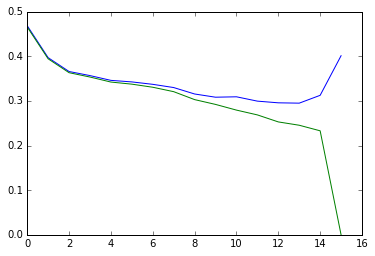

('best k = ', 5, 'min value of MSE = ', 0.29490853458495192)


In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(vaMse) #plot validation rmse
plt.plot(trMse)
plt.show()
kStar = ks[np.argmin(vaMse)]
print('best k = ', kStar, 'min value of MSE = ', np.min(vaMse))  #print best value of k and corresponding mse

In [92]:
#use test data to confirm results
knnTe = KNeighborsRegressor(n_neighbors=10)
knnTe.fit(xTrVa, yTrVa)
teErr = knnTe.predict(xTe) - yTe
teMse = np.sqrt(np.mean(teErr*teErr))
print(teMse)

0.32734276328


## Discussion:
When I run this several times (starting from train/test split), I get optimum k values that bounce around between 5 and 15.  The corresponding mean square errors (MSE) range from 0.29 to 0.38.  Generally the test errors are slightly smaller than the best MSE from cross validation.  Occasionally, the test error will be 30% or so higher than MSE from cross validation.  I'd probably deploy with k=10 or so to be a little conservative.  

Try scaling the data to zero mean and unit variance at the very beginning.  See if that improves performance.  



## ElasticNet CV on the same data set
For this problem we can start with the same xTrVa, xTe, yTrVa, yTe that were developed in the code above.  That's where this sample code below picks up the story. 

In [103]:
from sklearn.linear_model import ElasticNetCV
from math import sqrt
#xTrVa, xTe, yTrVa, yTe

enet = ElasticNetCV(l1_ratio=0.5, normalize=True, cv=10, n_jobs=-1)
enet.fit(xTrVa, yTrVa)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=-1,
       normalize=True, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [105]:
enet.mse_path_.shape

(100, 10)

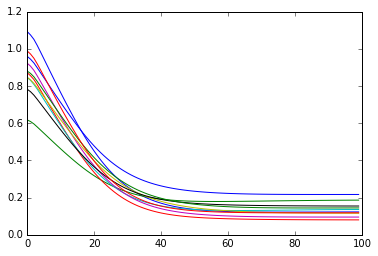

In [106]:
for i in range(10):
    plt.plot(enet.mse_path_[:,i])
plt.show()

In [107]:
meanErr = np.mean(enet.mse_path_, axis=1)
minIdx = np.argmin(meanErr)
print('index of mse min', minIdx, 'Min value of rmse', sqrt(meanErr[minIdx]))

('index of mse min', 83, 'Min value of rmse', 0.36999398926154475)


In [108]:
#check on test data to make sure it's in line with min from xvalidation
teErr = enet.predict(xTe) - yTe
teRmse = np.sqrt(np.mean(teErr*teErr))
print('RMSE on Test data', teRmse)

('RMSE on Test data', 0.43985946493371247)


In [111]:
np.where(enet.alphas_ == enet.alpha_)  #find index of alpha used in ElasticNetCV predict method - same as minimum mse index

(array([83]),)

In [113]:
print(np.sqrt(enet.mse_path_[83,:]))  #print rmse for each of the xval sets to see if this fits within their spread

[ 0.34972993  0.4292296   0.28452066  0.3659129   0.30910295  0.34252707
  0.39433946  0.46571946  0.37980514  0.34357328]


## Discussion
This model is generating reasonable answers.  Might get better results by fooling around with the l1 ratio parameter some.  The rmse on the test data is within the spread of the xval folds, so it's congruent with the values out of xvalidation. 